In [25]:
# -----------
# User Instructions
#
# Define a function smooth that takes a path as its input
# (with optional parameters for weight_data, weight_smooth,
# and tolerance) and returns a smooth path. The first and 
# last points should remain unchanged.
#
# Smoothing should be implemented by iteratively updating
# each entry in newpath until some desired level of accuracy
# is reached. The update should be done according to the
# gradient descent equations given in the instructor's note
# below (the equations given in the video are not quite 
# correct).
# -----------

from copy import deepcopy
from matplotlib import pyplot as plt

# thank you to EnTerr for posting this on our discussion forum
def printpaths(path,newpath):
    for old,new in zip(path,newpath):
        print('['+ ', '.join('%.3f'%x for x in old) + \
               '] -> ['+ ', '.join('%.3f'%x for x in new) +']')

# Don't modify path inside your function.
path = [[0, 0],
        [0, 1],
        [0, 2],
        [1, 2],
        [2, 2],
        [3, 2],
        [4, 2],
        [4, 3],
        [4, 4]]

def smooth(path, weight_data = 0.1, weight_smooth = 0.1, tolerance = 0.000001):
    global newpath
    # Make a deep copy of path into newpath
    newpath = deepcopy(path)

    #######################
    ### ENTER CODE HERE ###
    #######################
    change = tolerance
    while change >= tolerance:
        change = 0.0
        for i in range(1, len(path)-1):
            for j in range(len(path[0])):
                aux = newpath[i][j]
                newpath[i][j] += weight_data * (path[i][j] - newpath[i][j]) + weight_smooth * (newpath[i-1][j] + newpath[i+1][j] - 2.0 * newpath[i][j])
                change += abs(aux - newpath[i][j])
    return newpath # Leave this line for the grader!

printpaths(path,smooth(path))
print(newpath)

[0.000, 0.000] -> [0.000, 0.000]
[0.000, 1.000] -> [0.143, 0.857]
[0.000, 2.000] -> [0.429, 1.571]
[1.000, 2.000] -> [1.143, 1.857]
[2.000, 2.000] -> [2.000, 2.000]
[3.000, 2.000] -> [2.857, 2.143]
[4.000, 2.000] -> [3.571, 2.429]
[4.000, 3.000] -> [3.857, 3.143]
[4.000, 4.000] -> [4.000, 4.000]
[[0, 0], [0.14285738621349742, 0.8571426137865026], [0.42857188124937357, 1.5714281187506265], [1.1428577506154778, 1.8571422493845222], [2.000000676887908, 1.999999323112092], [2.8571434924678574, 2.1428565075321426], [3.5714290549505976, 2.4285709450494024], [3.857143110691271, 3.142856889308729], [4, 4]]


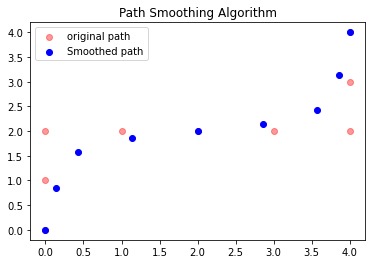

In [26]:
for i in range(len(path)):
    plt.scatter(path[i][0],path[i][1], color='red', alpha=0.4)
    plt.scatter(newpath[i][0],newpath[i][1],color='blue')
plt.legend(['original path','Smoothed path'])
plt.title('Path Smoothing Algorithm')
plt.show()

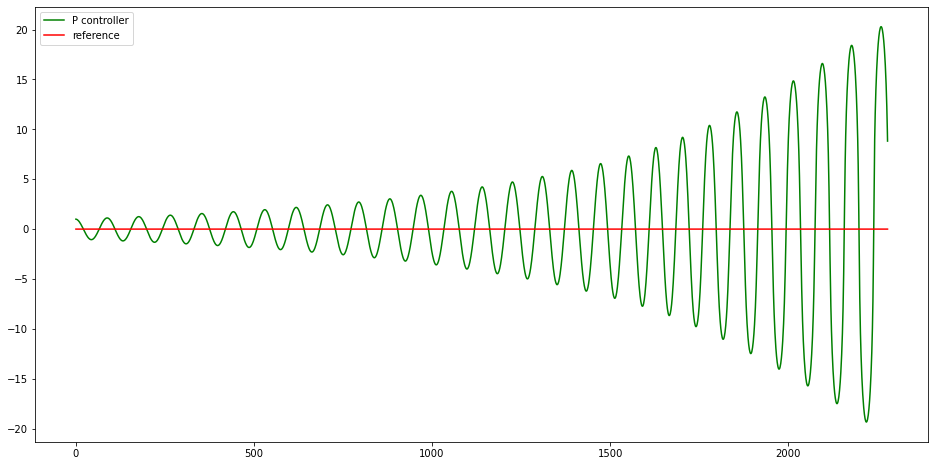

In [58]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The desired trajectory for the 
# robot is the x-axis. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau * crosstrack_error
#
# You'll only need to modify the `run` function at the bottom.
# ------------
 
import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run
robot = Robot()
robot.set(0.0, 1.0, 0.0)

def run(robot, tau, n=2500, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    for i in range(n):
        cte = robot.y
        steerAngle = -tau * cte
        robot.move(steerAngle, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory
    
x_trajectory, y_trajectory = run(robot, 0.1)
n = len(x_trajectory)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(x_trajectory, y_trajectory, 'g', label='P controller')
ax.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax.legend()
plt.show()


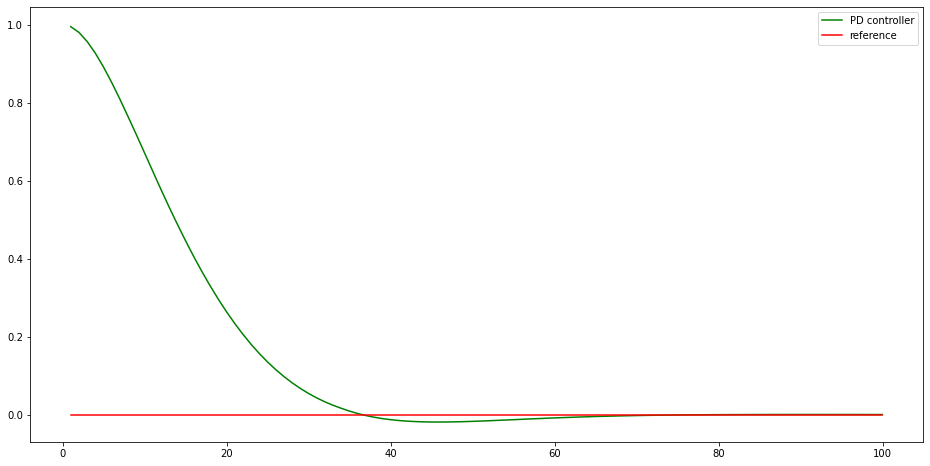

In [66]:
# -----------
# User Instructions
#
# Implement a PD controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE
# where differential crosstrack error (diff_CTE)
# is given by CTE(t) - CTE(t-1)
#
# Your code should print output that looks like
# the output shown in the video.
#
# ------------
############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run
robot = Robot()
robot.set(0, 1, 0)

def run(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    prev_cte = robot.y
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        prev_cte = cte
        steer = -tau_p * cte - tau_d * diff_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

x_trajectory, y_trajectory = run(robot,  0.2, 3.0)
n = len(x_trajectory)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax.legend()
plt.show()

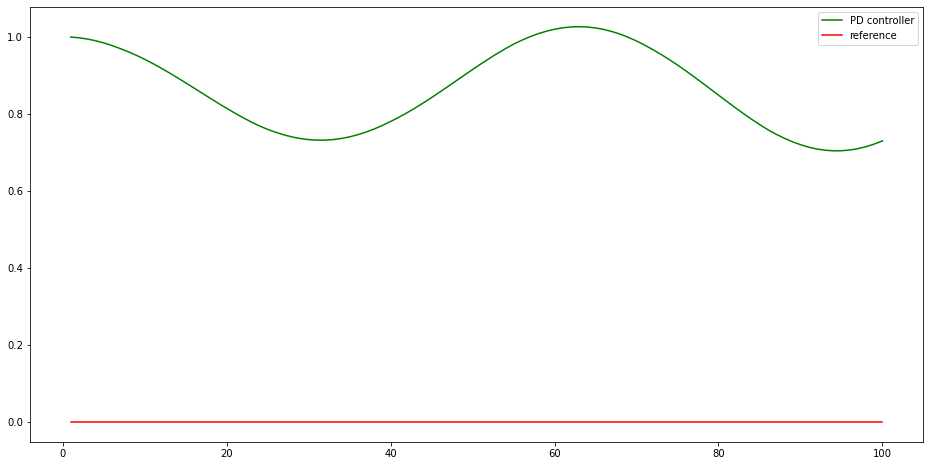

In [74]:
# Systematic Bias
robot = Robot()
robot.set(0, 1, 0)
robot.set_steering_drift(10.0/180.0*3.14) # add steering wheel 
x_trajectory, y_trajectory = run(robot,  0.2,0.0)
n = len(x_trajectory)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax.legend()
plt.show()

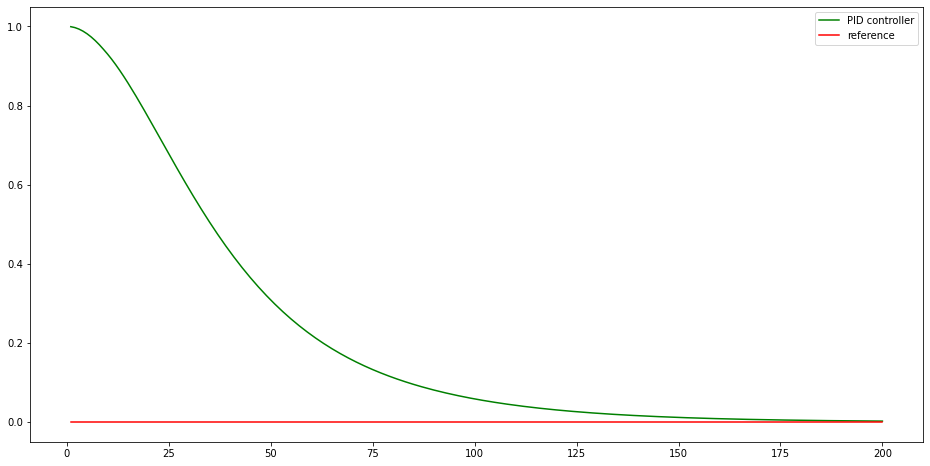

In [98]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
############### ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run

robot = Robot()
robot.set(0, 1, 0)
robot.set_steering_drift(10.0/180.0*3.14) # add steering wheel 

def run(robot, tau_p, tau_d, tau_i, n=200, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    prev_cte = robot.y
    int_cte = 0
    for i in range(n):
        cte = robot.y
        diff_cte = (cte - prev_cte) / speed
        prev_cte = cte
        int_cte += cte
        steer = -tau_p * cte - tau_d * diff_cte - tau_i * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

x_trajectory, y_trajectory = run(robot,  0.2, 3.0,0.004)
n = len(x_trajectory)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
ax.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax.legend()
plt.show()

Final twiddle error = 0.783152477895306653066


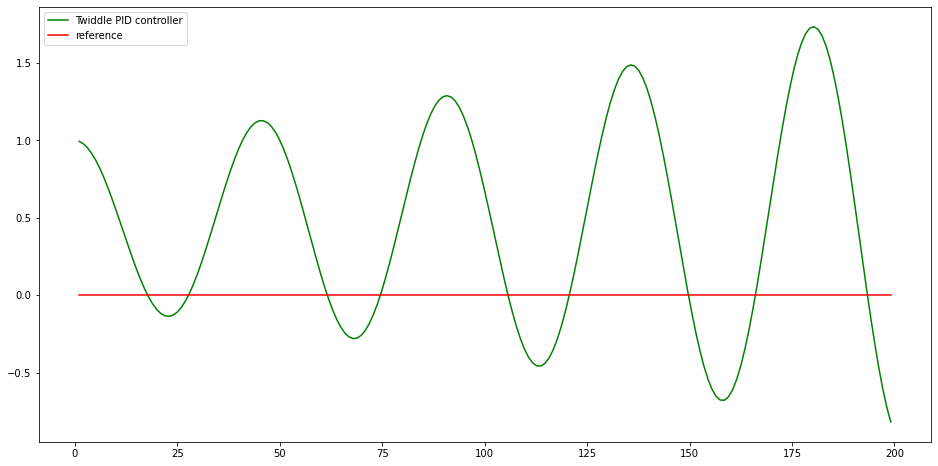

In [95]:
# ----------------
# User Instructions
#
# Implement twiddle as shown in the previous two videos.
# Your accumulated error should be very small!
#
# Your twiddle function should RETURN the accumulated
# error. Try adjusting the parameters p and dp to make
# this error as small as possible.
#
# Try to get your error below 1.0e-10 with as few iterations
# as possible (too many iterations will cause a timeout).
# No cheating!
# ------------

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run
import time

def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0.0, 1.0, 0.0)
    robot.set_steering_drift(10.0 / 180.0 * np.pi)
    return robot

# NOTE: We use params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    # TODO: your code here
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.2): 
    # TODO: Add code here
    # Don't forget to call `make_robot` before you call `run`!
    p = [0.0, 0.0, 0.0]
    dp = [1.0, 1.0, 1.0]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)

    it = 0
    while sum(dp) > tol:
        print("Iteration {}, best error = {}".format(it, best_err), end='\r')
        time.sleep(.1)
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err

params, err = twiddle()
print("Final twiddle error = {}".format(err))
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax1.legend()
plt.show()
